In [ ]:
 !git clone https://github.com/Stephen-Zhong1/Audio-Project.git

fatal: destination path 'Audio-Project' already exists and is not an empty directory.


In [ ]:
import os
import tensorflow as tf

from tensorflow import keras
import keras.layers as layers

import numpy as np
import matplotlib.pyplot as plt

import imghdr
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay
import tensorflow_datasets as tfds
%matplotlib inline

In [ ]:
training_data_path = "Audio-Project/converted-audio-test"

color_mode = "rgb"
number_color_channels = 3
image_size = (640, 480)
image_shape = image_size + (number_color_channels,)

def get_image_data(data_path, color_mode, image_size, seed = None, subset = None, validation_split = None):
    if subset:
        validation_split = 0.2
    raw_data_set = \
    tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        color_mode=color_mode,
        image_size=image_size,
        seed=seed,
        validation_split=validation_split, 
        subset=subset
    )
    
    raw_data_set.class_names.sort()
    
    return {
        "data": raw_data_set.cache().prefetch(
        buffer_size = tf.data.experimental.AUTOTUNE
        ),
        "classNames": raw_data_set.class_names
    }

In [ ]:
train_set = get_image_data(
    training_data_path,
    color_mode,
    image_size,
    seed = 42,
    subset = "training"
)
validation_set = get_image_data(
    training_data_path,
    color_mode,
    image_size,
    seed = 42,
    subset = "validation"
)

Found 80 files belonging to 2 classes.
Using 64 files for training.
Found 80 files belonging to 2 classes.
Using 16 files for validation.


In [ ]:
model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape = image_shape),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2)
])

In [ ]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 640, 480, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 640, 480, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 320, 240, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 320, 240, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 160, 120, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 160, 120, 64)     

In [ ]:
epochs = 8
history = model.fit(
  train_set['data'],
  validation_data = validation_set['data'],
  epochs=epochs
)

Epoch 1/8
2/2 [==============================] - 0s 204ms/step - loss: 0.6604 - accuracy: 0.5000 - val_loss: 0.6818 - val_accuracy: 0.5000
Epoch 2/8
2/2 [==============================] - 0s 199ms/step - loss: 0.6331 - accuracy: 0.7031 - val_loss: 0.6643 - val_accuracy: 0.7500
Epoch 3/8
2/2 [==============================] - 0s 204ms/step - loss: 0.5988 - accuracy: 0.8281 - val_loss: 0.6509 - val_accuracy: 0.6875
Epoch 4/8
2/2 [==============================] - 0s 228ms/step - loss: 0.5521 - accuracy: 0.8750 - val_loss: 0.6375 - val_accuracy: 0.7500
Epoch 5/8
2/2 [==============================] - 0s 219ms/step - loss: 0.5578 - accuracy: 0.7031 - val_loss: 0.6454 - val_accuracy: 0.5625
Epoch 6/8
2/2 [==============================] - 0s 203ms/step - loss: 0.4807 - accuracy: 0.8438 - val_loss: 0.6006 - val_accuracy: 0.8125
Epoch 7/8
2/2 [==============================] - 0s 208ms/step - loss: 0.4420 - accuracy: 0.8750 - val_loss: 0.5845 - val_accuracy: 0.8125
Epoch 8/8
2/2 [============

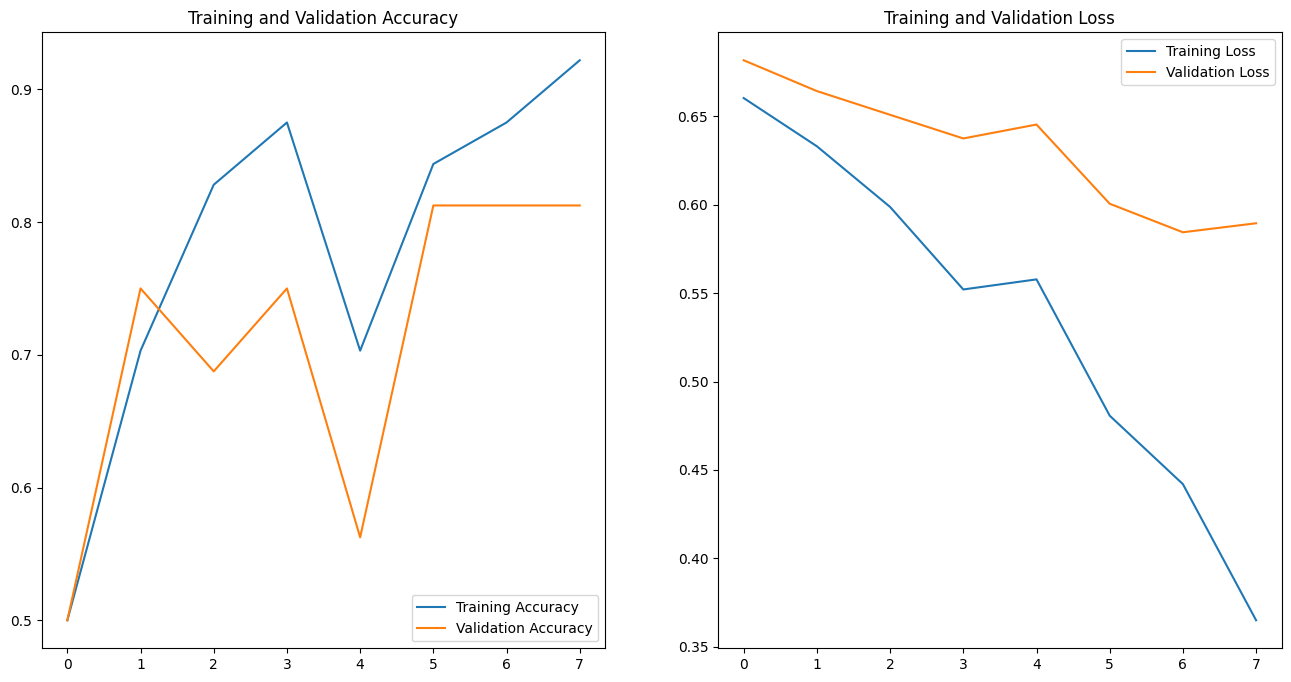

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
result = model.evaluate(validation_set['data'])

1/1 [==============================] - 0s 53ms/step - loss: 0.5896 - accuracy: 0.8125


In [ ]:
targets = []
results = []
for batch in validation_set['data']:
    targets.extend(batch[1].numpy().tolist())
    predictions = [np.argmax(p) for p in model.predict(batch[0])]
    results.extend(predictions)
y_pred = np.array(results)
y_test = np.array(targets)



1/1 [==============================] - 0s 160ms/step


0.8125
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16



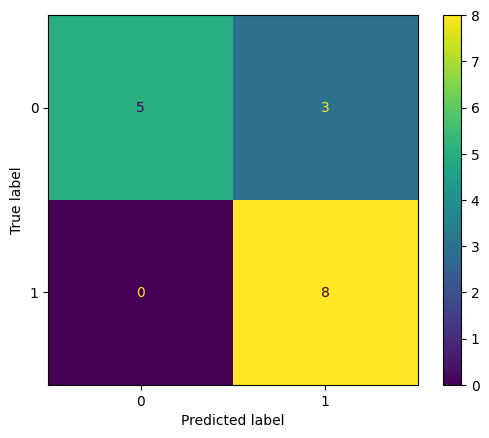

In [ ]:
print(accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

